**Abhishek Ghosh
ME21BTECH11001**

# Devenport Q Method

In [1]:
import numpy as np

# Body frame vectors
b1 = np.array([0.8273, 0.5541, -0.0920])
b2 = np.array([-0.8285, 0.5522, -0.0955])
b3 = np.array([0.1086, -0.8084, -0.5781])

# Inertial frame vectors
r1 = np.array([-0.1517, -0.9669, 0.2050])
r2 = np.array([-0.8393, 0.4494, -0.3044])
r3 = np.array([-0.0712, -0.8635, -0.4997])

# Weights
a1 = a2 = a3 = 1.0

# B matrix (attitude profile matrix)
B = a1 * np.outer(b1, r1) + a2 * np.outer(b2, r2) + a3 * np.outer(b3, r3)

# Compute symmetric K matrix for Davenport's Q-method
S = B + B.T
sigma = np.trace(B)
Z = np.array([
    B[1, 2] - B[2, 1],
    B[2, 0] - B[0, 2],
    B[0, 1] - B[1, 0]
])
K = np.zeros((4, 4))
K[0, 0] = sigma
K[0, 1:] = Z
K[1:, 0] = Z
K[1:, 1:] = S - sigma * np.eye(3)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(K)

# Get the eigenvector corresponding to the maximum eigenvalue
max_index = np.argmax(eigvals)
q = eigvecs[:, max_index]

# Normalize quaternion
q = q / np.linalg.norm(q)

q  # Quaternion [q0, q1, q2, q3]



array([-0.81111764, -0.19512339,  0.40333221,  0.37594968])

# Kalman Filter

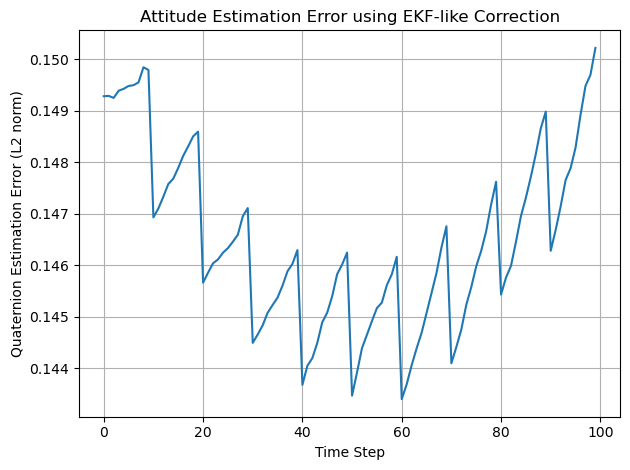

array([-0.72118591, -0.18059603,  0.50522493,  0.43820512])

In [11]:
import matplotlib.pyplot as plt

# Simulate EKF-based attitude estimation improvement EKF for non linear systems
# Assumptions:
# - True attitude remains constant (equal to q_true)
# - Gyro measurements have small bias and noise
# - Star tracker provides noisy quaternion measurement intermittently
# because of these the error initaially decreases but then starts increasing

np.random.seed(0)

# Ground truth quaternion (from previous computation)
q_true = np.array([-0.8111, -0.1951, 0.4033, 0.3759])
q_true /= np.linalg.norm(q_true)

# Simulation parameters
n_steps = 100
gyro_bias = np.array([0.01, -0.01, 0.005])  # rad/s
gyro_noise_std = 0.002
star_tracker_noise_std = 0.01
dt = 0.1  # seconds

# Initialize EKF state: quaternion + bias estimate
q_est = q_true + np.random.normal(0, 0.05, 4)
q_est /= np.linalg.norm(q_est)
bias_est = np.zeros(3)

q_est_history = []
q_true_history = []
error_history = []
final = np.array([0,0,0,0])

for step in range(n_steps):
    # Simulate gyro measurement
    omega_true = np.zeros(3)  # no actual rotation
    omega_measured = omega_true + gyro_bias + np.random.normal(0, gyro_noise_std, 3)

    # Prediction step (simple integration of quaternion)
    omega = omega_measured - bias_est
    Omega = np.array([
        [0, -omega[0], -omega[1], -omega[2]],
        [omega[0], 0, omega[2], -omega[1]],
        [omega[1], -omega[2], 0, omega[0]],
        [omega[2], omega[1], -omega[0], 0]
    ])
    q_dot = 0.5 * Omega @ q_est
    q_est += q_dot * dt
    q_est /= np.linalg.norm(q_est)
    final = q_est
    # Update step: star tracker every 10 steps
    if step % 10 == 0:
        q_measured = q_true + np.random.normal(0, star_tracker_noise_std, 4)
        q_measured /= np.linalg.norm(q_measured)
        # Simple correction (no full Kalman gain calc here for simplicity)
        q_est = 0.98 * q_est + 0.02 * q_measured
        q_est /= np.linalg.norm(q_est)

    # Log
    q_est_history.append(q_est.copy())
    q_true_history.append(q_true.copy())
    error = np.linalg.norm(q_true - q_est)
    error_history.append(error)

# Plot estimation error over time
plt.plot(error_history)
plt.xlabel('Time Step')
plt.ylabel('Quaternion Estimation Error (L2 norm)')
plt.title('Attitude Estimation Error using EKF-like Correction')
plt.grid(True)
plt.tight_layout()
plt.show()

# q_true
# final



# Spinning coin analysis

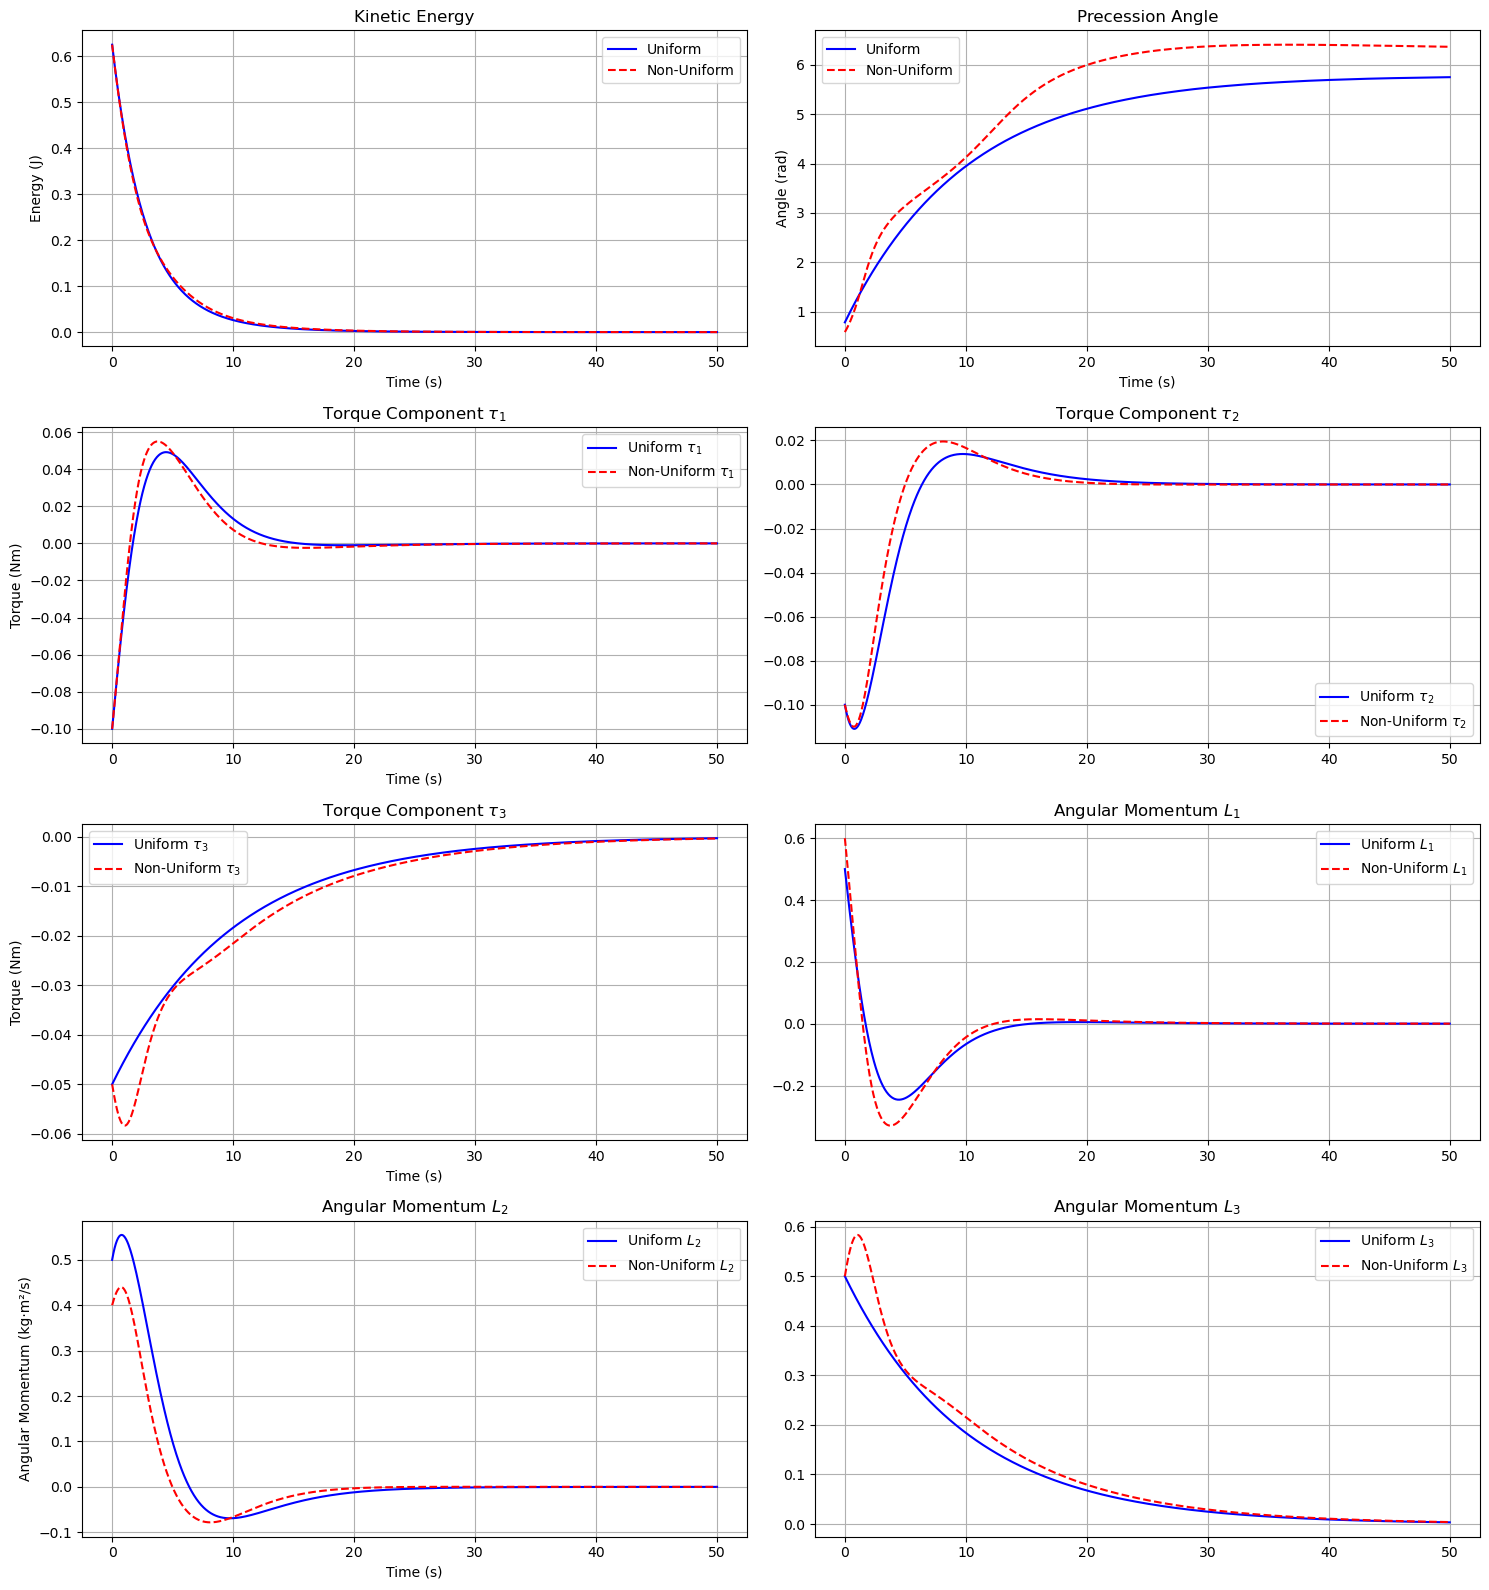

In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
k = 0.1                      # Damping coefficient
omega0 = [1.0, 1.0, 0.5]     # Initial angular velocity (rad/s)

# Uniform coin (I1 = I2)
I1, I2, I3 = 0.5, 0.5, 1.0
def domega_dt(t, omega):
    o1, o2, o3 = omega
    do1 = ((I2 - I3)/I1 * o2 * o3) - (k/I1) * o1
    do2 = ((I3 - I1)/I2 * o3 * o1) - (k/I2) * o2
    do3 = ((I1 - I2)/I3 * o1 * o2) - (k/I3) * o3
    return [do1, do2, do3]
sol = solve_ivp(domega_dt, (0, 50), omega0, t_eval=np.linspace(0, 50, 1000))
t = sol.t
o1, o2, o3 = sol.y
KE = 0.5 * (I1*o1**2 + I2*o2**2 + I3*o3**2)
tau1, tau2, tau3 = -k*o1, -k*o2, -k*o3
L1, L2, L3 = I1*o1, I2*o2, I3*o3
phi = np.arctan2(L2, L1)  # Precession angle

# Non-uniform coin (I1 ≠ I2)
I1_nu, I2_nu, I3_nu = 0.6, 0.4, 1.0
def domega_dt_nu(t, omega):
    o1, o2, o3 = omega
    do1 = ((I2_nu - I3_nu)/I1_nu * o2 * o3) - (k/I1_nu) * o1
    do2 = ((I3_nu - I1_nu)/I2_nu * o3 * o1) - (k/I2_nu) * o2
    do3 = ((I1_nu - I2_nu)/I3_nu * o1 * o2) - (k/I3_nu) * o3
    return [do1, do2, do3]
sol_nu = solve_ivp(domega_dt_nu, (0, 50), omega0, t_eval=np.linspace(0, 50, 1000))
o1_nu, o2_nu, o3_nu = sol_nu.y
KE_nu = 0.5 * (I1_nu*o1_nu**2 + I2_nu*o2_nu**2 + I3_nu*o3_nu**2)
tau1_nu, tau2_nu, tau3_nu = -k*o1_nu, -k*o2_nu, -k*o3_nu
L1_nu, L2_nu, L3_nu = I1_nu*o1_nu, I2_nu*o2_nu, I3_nu*o3_nu
phi_nu = np.arctan2(L2_nu, L1_nu)  # Precession angle

# Create combined plots
fig, axs = plt.subplots(4, 2, figsize=(15, 16))

# Energy
axs[0, 0].plot(t, KE, 'b', label='Uniform')
axs[0, 0].plot(t, KE_nu, 'r--', label='Non-Uniform')
axs[0, 0].set_title('Kinetic Energy')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Energy (J)')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Precession Angle
axs[0, 1].plot(t, np.unwrap(phi), 'b', label='Uniform')
axs[0, 1].plot(t, np.unwrap(phi_nu), 'r--', label='Non-Uniform')
axs[0, 1].set_title('Precession Angle')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Angle (rad)')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Torque Components
axs[1, 0].plot(t, tau1, 'b', label=r'Uniform $\tau_1$')
axs[1, 0].plot(t, tau1_nu, 'r--', label=r'Non-Uniform $\tau_1$')
axs[1, 0].set_title(r'Torque Component $\tau_1$')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Torque (Nm)')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].plot(t, tau2, 'b', label=r'Uniform $\tau_2$')
axs[1, 1].plot(t, tau2_nu, 'r--', label=r'Non-Uniform $\tau_2$')
axs[1, 1].set_title(r'Torque Component $\tau_2$')
axs[1, 1].grid(True)
axs[1, 1].legend()

axs[2, 0].plot(t, tau3, 'b', label=r'Uniform $\tau_3$')
axs[2, 0].plot(t, tau3_nu, 'r--', label=r'Non-Uniform $\tau_3$')
axs[2, 0].set_title(r'Torque Component $\tau_3$')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Torque (Nm)')
axs[2, 0].grid(True)
axs[2, 0].legend()

# Angular Momentum Components
axs[2, 1].plot(t, L1, 'b', label=r'Uniform $L_1$')
axs[2, 1].plot(t, L1_nu, 'r--', label=r'Non-Uniform $L_1$')
axs[2, 1].set_title('Angular Momentum $L_1$')
axs[2, 1].grid(True)
axs[2, 1].legend()

axs[3, 0].plot(t, L2, 'b', label=r'Uniform $L_2$')
axs[3, 0].plot(t, L2_nu, 'r--', label=r'Non-Uniform $L_2$')
axs[3, 0].set_title('Angular Momentum $L_2$')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Angular Momentum (kg·m²/s)')
axs[3, 0].grid(True)
axs[3, 0].legend()

axs[3, 1].plot(t, L3, 'b', label=r'Uniform $L_3$')
axs[3, 1].plot(t, L3_nu, 'r--', label=r'Non-Uniform $L_3$')
axs[3, 1].set_title('Angular Momentum $L_3$')
axs[3, 1].grid(True)
axs[3, 1].legend()

plt.tight_layout()
plt.show()

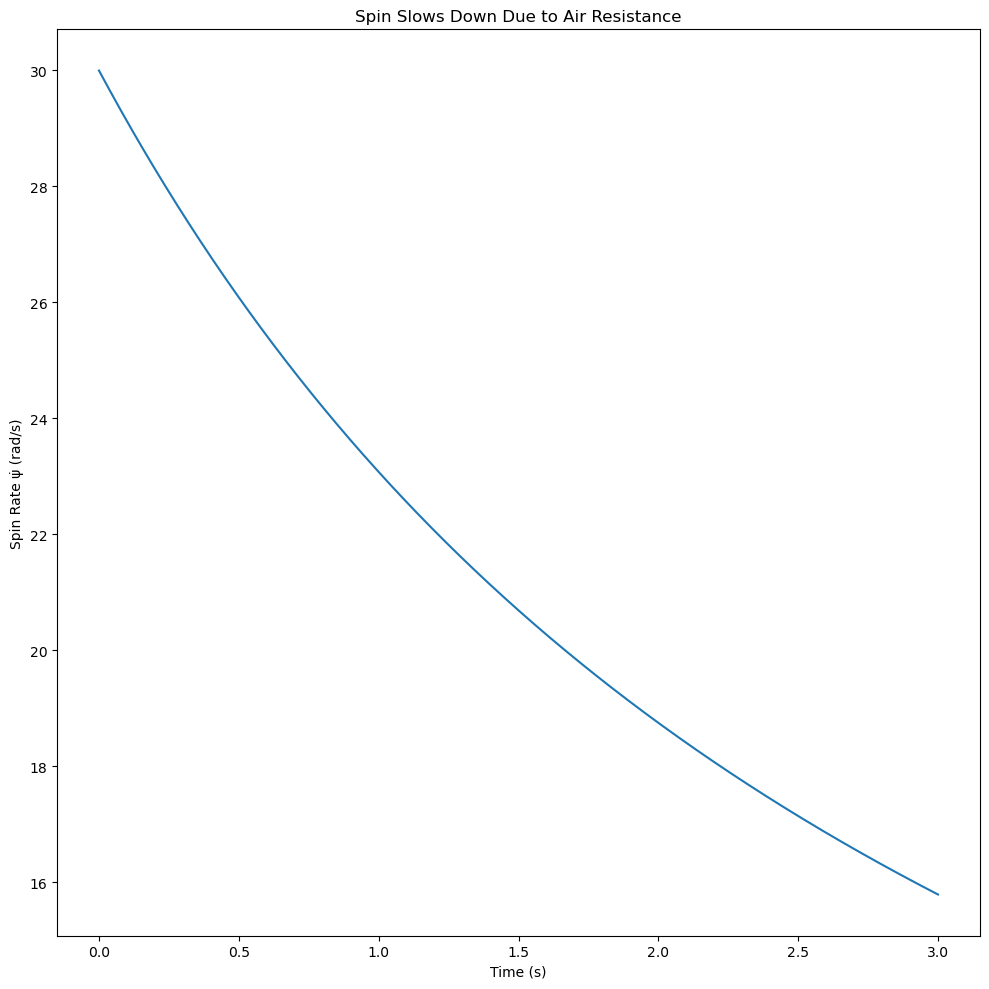

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
I1 = 1.0      # Moment of inertia around transverse axis
I3 = 0.5      # Moment of inertia around symmetry axis (I3 < I1 for a thin disk)
g = 9.81      # Gravity
m = 0.05      # Mass of coin
R = 0.015     # Radius of coin
C_air = 0.01  # Air drag coefficient
C_roll = 0.005  # Rolling friction coefficient

# Time settings
dt = 0.001
T = 3.0
N = int(T/dt)
t = np.linspace(0, T, N)

# Initial conditions
theta = np.pi / 4  # 45 degrees tilt
phi = 0.0
psi = 0.0

omega_theta = 0.0
omega_phi = 10.0  # Initial precession rate
omega_psi = 30.0  # Initial spin rate

theta_arr = []
phi_arr = []
omega_phi_arr = []
omega_psi_arr = []

for i in range(N):
    # Angular velocities
    omega1 = omega_phi * np.sin(theta)
    omega2 = omega_theta
    omega3 = omega_psi + omega_phi * np.cos(theta)

    # Torques due to gravity (approximated about contact point)
    torque_gravity = m * g * R * np.sin(theta)
    domega_theta = torque_gravity / I1

    # Damping due to rolling and air resistance
    damping_phi = -C_roll * omega_phi - C_air * omega_phi**2
    damping_psi = -C_air * omega_psi**2

    # Update angular rates
    omega_theta += domega_theta * dt
    omega_phi += damping_phi * dt
    omega_psi += damping_psi * dt

    # Update angles
    theta -= 0.5 * C_roll * dt  # slow flattening
    phi += omega_phi * dt
    psi += omega_psi * dt

    # Store for plotting
    theta_arr.append(theta)
    phi_arr.append(phi)
    omega_phi_arr.append(omega_phi)
    omega_psi_arr.append(omega_psi)

# Convert theta to degrees for visualization
theta_deg = np.degrees(theta_arr)

# Plotting results
fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharex=True)



axs.plot(t, omega_psi_arr)
axs.set_ylabel("Spin Rate ψ̇ (rad/s)")
axs.set_xlabel("Time (s)")
axs.set_title("Spin Slows Down Due to Air Resistance")

plt.tight_layout()
plt.show()
